In [1]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np

from qiskit import *

import matplotlib.pyplot as plt

from qiskit.quantum_info import Statevector

In [4]:
freq_0 = 4.9e9
amp_0 = 0.059501279242309815
beta_0 =-0.9899497487437185
ef_freq_0 = 4.5e9
ef_amp_0 = 0.04091261035812275
ef_beta_0 = -0.015075376884422287

freq_1 = 5.5e9
amp_1 = 0.05039825490571683
beta_1 = -2.8282828282828283
ef_freq_1 = 5.2e9
ef_amp_1 = 0.03587788534159534
ef_beta_1 = -2.8282828282828283

dt = 1/4.5e9

In [5]:
import numpy as np
from qiskit import pulse
from qiskit_dynamics import Solver, DynamicsBackend 
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate, HGate
from qiskit.circuit import Parameter, Gate
from qiskit.providers.backend import QubitProperties
from qiskit.transpiler import InstructionProperties
from qiskit.providers.models import PulseDefaults


class TwoQutritPulseSimulator():
    def __init__(
        self,
        qubit_frequency_0 = 4.9e9,
        qubit_frequency_1 = 5.5e9,
        anharmonicity_0 = -0.4e9,
        anharmonicity_1 = -0.3e9,
        drive_strength_0 = 0.22e9,
        drive_strength_1 = 0.26e9,
    ):
        dim = 3

        self.v0 = qubit_frequency_0
        self.anharmon_0 = anharmonicity_0
        self.r0 = drive_strength_0
        
        self.v1 = qubit_frequency_1
        self.anharmon_1 = anharmonicity_1
        self.r1 = drive_strength_1
        
        self.J = 2.7e6
        
        a = np.diag(np.sqrt(np.arange(1, dim)), 1)
        adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
        N = np.diag(np.arange(dim))
        
        ident = np.eye(dim, dtype=complex)
        full_ident = np.eye(dim**2, dtype=complex)
        
        N0 = np.kron(ident, N)
        N1 = np.kron(N, ident)
        
        a0 = np.kron(ident, a)
        a1 = np.kron(a, ident)
        
        a0dag = np.kron(ident, adag)
        a1dag = np.kron(adag, ident)
        
        
        static_ham0 = 2 * np.pi * self.v0 * N0 + np.pi * self.anharmon_0 * N0 * (N0 - full_ident)
        static_ham1 = 2 * np.pi * self.v1 * N1 + np.pi * self.anharmon_1 * N1 * (N1 - full_ident)
        
        static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * self.J * ((a0 + a0dag) @ (a1 + a1dag))
        
        drive_op0 = 2 * np.pi * self.r0 * (a0 + a0dag)
        drive_op1 = 2 * np.pi * self.r1 * (a1 + a1dag)

        # build solver
        dt = 1/4.5e9
        
        self.solver = Solver(
            static_hamiltonian=static_ham_full,
            hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
            # rotating_frame=static_ham_full,
            hamiltonian_channels=["d0", "d1", "u0", "u1"],
            channel_carrier_freqs={"d0": self.v0, "d1": self.v1, "u0": self.v1, "u1": self.v0},
            dt=dt,
            array_library="jax",
        )

        # Consistent solver option to use throughout notebook
        solver_options = {"method": "jax_odeint", "atol": 1e-10, "rtol": 1e-10, "hmax": dt}
        
        self.backend = DynamicsBackend(
            solver=self.solver,
            subsystem_dims=[dim, dim], # for computing measurement data
            solver_options=solver_options, # to be used every time run is called
            max_outcome_level=dim,
        )

        # self.backend.set_options(
        #     defaults = PulseDefaults.from_dict(
        #         {
        #             "qubit_freq_est": [self.v0, self.v1],
        #             "meas_freq_est": [0, 0],
        #             "buffer": 0,
        #             "pulse_library": [],
        #             "cmd_def":[]
        #         }
        #     )
        # )

        self.target = self.backend.target

        # qubit properties
        self.target.qubit_properties = [QubitProperties(frequency=self.v0), QubitProperties(frequency=self.v1)]
        
        #####################################################################################
        ##### add instructions for qutrits #####

        x01_gate = Gate('x01', 1, [])
        
        with pulse.build() as x01_0:
            pulse.Play(pulse.Gaussian(320, 0.5, 80), pulse.DriveChannel(0))
        
        with pulse.build() as x01_1:
            pulse.Play(pulse.Gaussian(320, 0.5, 80), pulse.DriveChannel(1))

        self.target.add_instruction(
            x01_gate,
            {
                (0,): InstructionProperties(calibration=x01_0), 
                (1,): InstructionProperties(calibration=x01_1)
            }
        )
        
        # self.target.add_instruction(XGate(), properties={(0,): None, (1,): None})
        # self.target.add_instruction(SXGate(), properties={(0,): None, (1,): None})
        
        self.target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})
        
        #### Add RZ instruction as phase shift for drag cal  #####
        phi = Parameter("phi")
        with pulse.build() as rz0:
            pulse.shift_phase(phi, pulse.DriveChannel(0))
            pulse.shift_phase(phi, pulse.ControlChannel(1))
        
        with pulse.build() as rz1:
            pulse.shift_phase(phi, pulse.DriveChannel(1))
            pulse.shift_phase(phi, pulse.ControlChannel(0))
        
        self.target.add_instruction(
            RZGate(phi),
            {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
        )

        ##################################################################################

        self.backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

    def get_backend(self):
        return self.backend

    def get_solver(self):
        return self.solver

    def get_target(self):
        return self.target

In [6]:
sim = TwoQutritPulseSimulator()
target = sim.get_target()
backend = sim.get_backend()

In [7]:
dchan0 = pulse.DriveChannel(0)
dchan1 = pulse.DriveChannel(1)

uchan0 = pulse.ControlChannel(0)
uchan1 = pulse.ControlChannel(1)

achan0 = pulse.AcquireChannel(0)
achan1 = pulse.AcquireChannel(1)

memslot = pulse.MemorySlot(0)

In [8]:
def bell_fidelity(state):
    omega = (-1 + (np.sqrt(3)*1j))/2
    base_states = [
        Statevector(np.array([1/np.sqrt(3), 0, 0, 0, 1/np.sqrt(3), 0, 0, 0, 1/np.sqrt(3)])),
        Statevector(np.array([1/np.sqrt(3), 0, 0, 0, omega/np.sqrt(3), 0, 0, 0, (omega**2)/np.sqrt(3)])),
        Statevector(np.array([1/np.sqrt(3), 0, 0, 0, (omega**2)/np.sqrt(3), 0, 0, 0, omega/np.sqrt(3)])),
        Statevector(np.array([0, 1/np.sqrt(3), 0, 0, 0, 1/np.sqrt(3), 1/np.sqrt(3), 0, 0])),
        Statevector(np.array([0, 1/np.sqrt(3), 0, 0, 0, omega/np.sqrt(3), (omega**2)/np.sqrt(3), 0, 0])),
        Statevector(np.array([0, 1/np.sqrt(3), 0, 0, 0, (omega**2)/np.sqrt(3), omega/np.sqrt(3), 0, 0])),
        Statevector(np.array([0, 0, 1/np.sqrt(3), 1/np.sqrt(3), 0, 0, 0, 1/np.sqrt(3), 0])),
        Statevector(np.array([0, 0, 1/np.sqrt(3), omega/np.sqrt(3), 0, 0, 0, (omega**2)/np.sqrt(3), 0])),
        Statevector(np.array([0, 0, 1/np.sqrt(3), (omega**2)/np.sqrt(3), 0, 0, 0, omega/np.sqrt(3), 0])),
    ]
    
    fid = 0
    for bstate in base_states:
        new_fid = np.absolute(bstate.data.dot(state.data))**2
        if new_fid > fid:
            fid = new_fid
    return fid

In [9]:
from qiskit.quantum_info.states import Statevector
from qiskit.quantum_info import *
from qiskit.quantum_info import *
import scipy.linalg as la

In [10]:
dt = 1/4.5e9

In [11]:
def qubit_concur(state):
    rho = DensityMatrix(state).data
    yy_mat = np.fliplr(np.diag([-1, 1, 1, -1]))
    sigma = rho.dot(yy_mat).dot(rho.conj()).dot(yy_mat)
    w = np.sort(np.real(la.eigvals(sigma)))
    w = np.sqrt(np.maximum(w, 0.0))
    
    return max(0.0, w[-1] - np.sum(w[0:-1]))

def qutrit_concur(state):
    y = state.data
    concur = np.sqrt((3*(np.abs(y[0]*y[4] - y[1]*y[3])**2
              + np.abs(y[2]*y[3] - y[0]*y[5])**2
              + np.abs(y[1]*y[5] - y[2]*y[4])**2
              + np.abs(y[1]*y[6] - y[0]*y[7])**2
              + np.abs(y[0]*y[8] - y[2]*y[6])**2
              + np.abs(y[3]*y[7] - y[4]*y[6])**2
              + np.abs(y[5]*y[6] - y[3]*y[8])**2
              + np.abs(y[2]*y[7] - y[1]*y[8])**2
              + np.abs(y[4]*y[8] - y[5]*y[7])**2)
             ))
    return concur

In [48]:
theta_1 = 2*np.acos(np.sqrt(1/3))
theta_2 = 2*np.acos(np.sqrt(1/2))

def bell_state_pulse():
    
    with pulse.build(name="cr_0") as bell_pulse:            
        pulse.set_frequency(freq_0, dchan0)
        pulse.play(pulse.Drag(320, (theta_1/np.pi)*amp_0, 80, beta_0, limit_amplitude=False), dchan0)
        pulse.set_frequency(ef_freq_0, dchan0)
        pulse.play(pulse.Drag(320, (theta_2/np.pi)*ef_amp_0, 80, ef_beta_0, limit_amplitude=False), dchan0)
        
        delay_time = 640
        
        pulse.delay(delay_time, uchan0)
        pulse.set_frequency(freq_1, uchan0)
        pulse.play(pulse.GaussianSquare(1350, 2, 76, 0.9*1350, limit_amplitude=False), uchan0)
        
        delay_time = delay_time + 1350
        
        pulse.delay(delay_time, dchan1)
        pulse.set_frequency(ef_freq_1, dchan1)
        pulse.shift_phase(-np.pi/2, dchan1)
        pulse.play(pulse.Drag(320, ((np.pi/2)/np.pi)*ef_amp_1, 80, ef_beta_1, limit_amplitude=False), dchan1)
        pulse.shift_phase(np.pi/2, dchan1)

        delay_time = 320
        
        pulse.delay(delay_time, uchan0)
        pulse.set_frequency(ef_freq_1, uchan0)
        pulse.play(pulse.GaussianSquare(450, 1, 76, 0.9*450, limit_amplitude=False), uchan0)
        
        delay_time = 450
        
        pulse.delay(delay_time, dchan1)
        
        pulse.set_frequency(freq_1, dchan1)
        pulse.play(pulse.Drag(320, amp_1, 80, beta_1, limit_amplitude=False), dchan1)
        
#         pulse.delay(delay_time + 7700 + 640, achan0)
#         pulse.delay(delay_time + 7700 + 640, achan1)
        
#         pulse.acquire(1, achan0, pulse.MemorySlot(1))
#         pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return bell_pulse


bell_pulse = bell_state_pulse()

# bell_job = backend.run(bell_pulse, meas_level=2, max_outcome_level=2, shots=10000)

# y0 = Statevector([1,0,0,0,0,0,0,0,0])
# bell_job = backend.solve(bell_pulse, t_span = [0., 8980*dt], y0=y0)

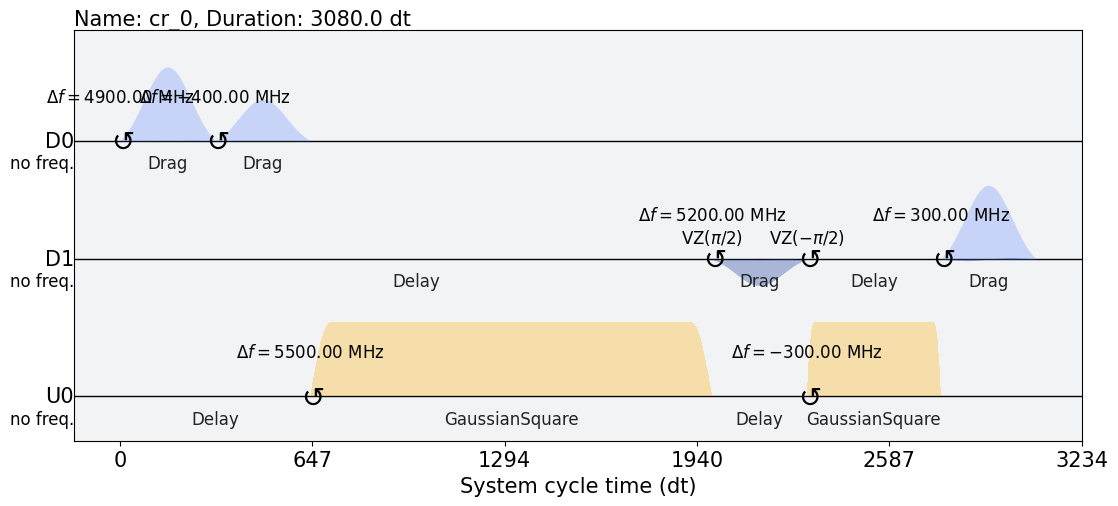

In [47]:
bell_pulse.draw()

In [49]:
y0 = Statevector([1,0,0,0,0,0,0,0,0])
bell_job = backend.solve(bell_pulse, t_span = [0., 3100*dt], y0=y0)

In [50]:
t_state = bell_job[0].y[-1]
print(qutrit_concur(t_state))

0.9291757996480149


In [51]:
print(np.round(t_state.data, 4))

[-0.0169-0.5506j -0.0657+0.0809j -0.1639+0.0129j  0.0352+0.0531j
 -0.3585+0.4284j -0.0574-0.0888j -0.0617-0.1297j  0.0498+0.0901j
 -0.3532+0.4187j]


In [52]:
print(np.round(t_state.probabilities(), 3))

[0.303 0.011 0.027 0.004 0.312 0.011 0.021 0.011 0.3  ]


In [53]:
print(bell_fidelity(t_state))

0.3557821221066804


In [55]:
probs = t_state.probabilities()

<BarContainer object of 9 artists>

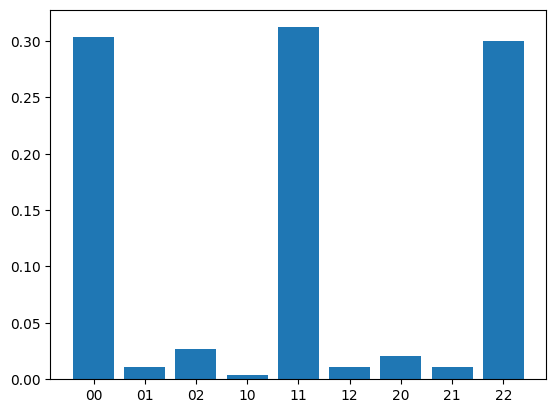

In [56]:
basis_states = ['00','01','02','10','11','12','20','21','22']
# basis_counts = []

# for state in basis_states:
#     if state in counts:
#         basis_counts.append(counts[state]/10000)
#     else:
#         basis_counts.append(0)

# plt.figure(figsize=(18,7))
plt.bar(basis_states, probs)

In [118]:
dt = 1/4.5e9
print(9000*dt/1e-9)

1999.9999999999998
